In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_stata("hpd_correction/Eviction_Building_Panel_Gardner_200307to201312_v1.dta")

In [3]:
df['total_evic'] = df['atfault'] + df['nofault']

df['nofault_per_unit'] = (df['nofault'] / df['initial_newUNITS'])
df['total_evic_per_unit'] = (df['total_evic'] / df['initial_newUNITS'])
df['atfault_per_unit'] = (df['atfault'] / df['initial_newUNITS'])

df.groupby('initial_rentcontrol').agg(
    {'atfault_per_unit': "mean", "nofault_per_unit": "mean", "total_evic_per_unit": "mean"}) * 12

,atfault_per_unit,nofault_per_unit,total_evic_per_unit
initial_rentcontrol,,,
0.0,0.002301,0.000082,0.002383
1.0,0.002765,0.002417,0.005182


In [4]:
df_year = df.groupby(
    ['MAP_BLK_LOT', 'year', 'newYRBLT', 'initial_newUNITS', 'initial_rentcontrol']).agg(
    {'atfault': "sum", "nofault": "sum", "total_evic": "sum", "month": "count"}
).reset_index().rename(columns={'month':'months_obs'})

df_year['nofault_per_unit_per_month'] = (df_year['nofault'] / df_year['initial_newUNITS']) / df_year['months_obs']
df_year['atfault_per_unit_per_month'] = (df_year['atfault'] / df_year['initial_newUNITS']) / df_year['months_obs']
df_year['total_evic_per_unit_per_month'] = (df_year['total_evic'] / df_year['initial_newUNITS']) / df_year['months_obs']

df_year['nofault_per_unit_per_yr'] = df_year['nofault_per_unit_per_month'] * 12
df_year['total_evic_per_unit_per_yr'] = df_year['total_evic_per_unit_per_month'] * 12
df_year['atfault_per_unit_per_yr'] = df_year['atfault_per_unit_per_month'] * 12

In [17]:
rd_plot_df = df_year[
    (df_year['newYRBLT'] > 1957) &
    (df_year['newYRBLT'] < 2003) &
    (df_year['initial_newUNITS'] > 0)
]

(1955.0, 2005.0)

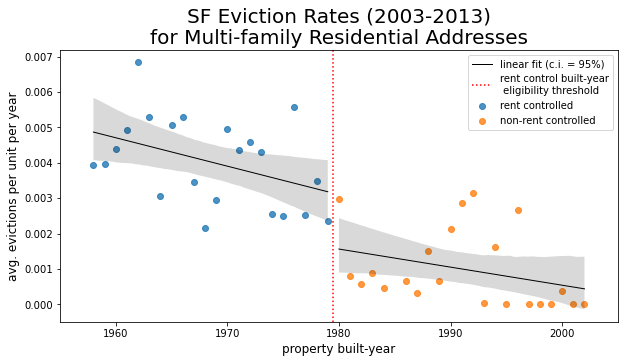

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

yr_vs_ev = rd_plot_df.groupby('newYRBLT').agg({"total_evic_per_unit_per_yr": 'mean'}).reset_index()
yr_vs_ev1 = yr_vs_ev[(yr_vs_ev['newYRBLT'] <= 1979) & (yr_vs_ev['newYRBLT'] > 1957)]
yr_vs_ev2 = yr_vs_ev[(yr_vs_ev['newYRBLT'] >= 1980) & (yr_vs_ev['newYRBLT'] < 2003)
                     & (yr_vs_ev['newYRBLT'] != 1985)  # 1985 is weirdly high outlier
                    ]
sns.regplot(
    x='newYRBLT', y='total_evic_per_unit_per_yr', data=yr_vs_ev1, ax=ax, truncate=True,
    label='rent controlled', line_kws={'color':'k', 'lw':1, 'label':'linear fit (c.i. = 95%)', 'zorder': 0})
sns.regplot(
    x='newYRBLT', y='total_evic_per_unit_per_yr', data=yr_vs_ev2, ax=ax, truncate=True,
    label='non-rent controlled', line_kws={'color':'k', 'lw':'1',  'zorder': 0})
ax.axvline(1979.5, ls=':', c='r', label='rent control built-year\n eligibility threshold')
ax.legend()
_ = ax.set_xlabel("property built-year", fontsize=12)
_ = ax.set_ylabel("avg. evictions per unit per year", fontsize=12,)
_ = ax.set_title("SF Eviction Rates (2003-2013)\nfor Multi-family Residential Addresses", fontsize=20)
ax.set_xlim((1955, 2005))